# 프로젝트: CutMix 또는 Mixup 비교실험

### 1. Augmentation을 적용한 데이터셋 만들기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

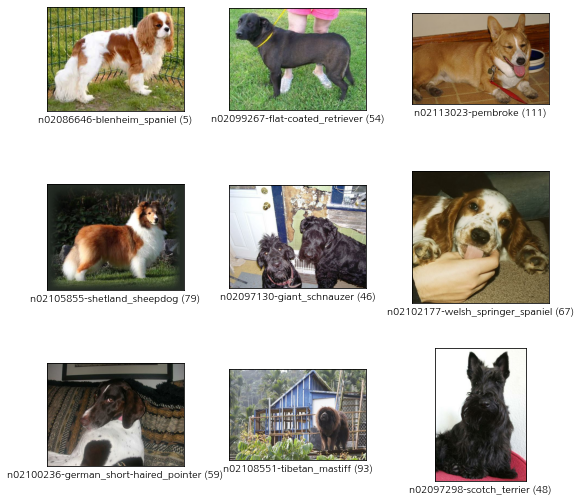

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

### 2. 모델 만들기

### 3. 모델 훈련하기

### 4. 훈련 과정 시각화하기

### 5. Augmentation에 의한 모델 성능 비교

# 프로젝트를 마치며...